In [15]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

ImportError: ignored

In [0]:
with open('data/trimmed_review_150k.json') as json_file: # Open json file to load
    data = json.load(json_file)
    
neg_all_reviews = [] # 1 star reviews
pos_all_reviews = [] # 5 star reviews

data_all = []
i=0

for review in data['Review:Rating']: # For each review
    if review['stars'] == 1.0:
#         neg_all_reviews.append(review['review'])
        data_all.append((review['review'],"One Star"))
    elif review['stars'] == 5.0:
#         pos_all_reviews.append(review['review'])
        if i<20000:
            data_all.append((review['review'],"Five Star"))
            i+=1

#print(len(neg_all_reviews), len(pos_all_reviews))

# neg_reviews = neg_all_reviews[:10000]
# pos_reviews = pos_all_reviews[:30000]

# unsup_reviews = neg_all_reviews[10000:] + pos_all_reviews[30000:]



In [0]:
df = pd.DataFrame(data_all, columns =['narrative','Product'])

In [5]:
df

,narrative,Product
0,Total bill for this horrible service? Over $8G...,One Star
1,I *adore* Travis at the Hard Rock's new Kelly ...,Five Star
2,I have to say that this office really has it t...,Five Star
3,Went in for a lunch. Steak sandwich was delici...,Five Star
4,Today was my second out of three sessions I ha...,One Star
...,...,...
41956,Just a little PSA: I'm new to the area and tho...,One Star
41957,Horrible does not describe this experience. Th...,One Star
41958,Yucky. The person who seated us didn't seem in...,One Star
41959,"I really DO NOT recommend this place, horrible...",One Star


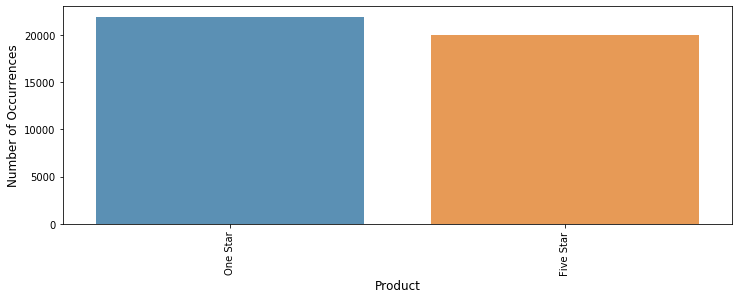

In [6]:
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [0]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "html.parser").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [0]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
# nltk.download()
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [0]:
# nltk.download("all")

In [0]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
# model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
model_dbow.build_vocab([x for x in train_tagged.values])

In [18]:
%%time
for epoch in range(100):
    # model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

CPU times: user 12min 46s, sys: 20.9 s, total: 13min 7s
Wall time: 7min 11s


In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors 

In [0]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [21]:
test['Product'].value_counts()

One Star     6593
Five Star    5996
Name: Product, dtype: int64

In [22]:
train['Product'].value_counts()

One Star     15368
Five Star    14004
Name: Product, dtype: int64

In [23]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Testing accuracy 0.5403924060687902
Testing F1 score: 0.5342055632596782


In [24]:
from sklearn.linear_model import SGDClassifier
lr = SGDClassifier(loss='log', penalty='l1')
lr.fit(X_train, y_train)
print('Test Accuracy: {}'.format(lr.score(X_test, y_test)))

Test Accuracy: 0.5442052585590595


In [25]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 
clf.score(X_test,y_test)

0.5329255699420129

In [0]:
len(X_train)